## 1. Needed libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os, glob, pickle, skimage.io, pathlib
import numpy as np
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Lambda
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

2024-08-15 13:41:33.665979: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.environ['XLA_FLAGS'] = '--xla_gpu_strict_conv_algorithm_picker=false'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## 2. Configuration Variables

In [4]:
patch_dir = "/disk2/user/cormey/outputs/Tilted_images/034_RJ.D1"
extracted_features_save_adr = "/disk2/user/cormey/outputs/CNN_outputs/extracted_features_34D.pickle"
network_weights_address = "/disk2/user/cormey/KimiaNet/KimiaNetKerasWeights.h5"
network_input_patch_width = 1000
batch_size = 16
img_format = 'jpg'
use_gpu = True

if use_gpu:
    os.environ['NVIDIA_VISIBLE_DEVICES'] = '0'
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
else:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## 3. Preprocessing and Feature Extraction Functions

In [23]:
def preprocessing_fn(input_batch, network_input_patch_width):
    org_input_size = tf.shape(input_batch)[1]
    scaled_input_batch = tf.cast(input_batch, 'float32') / 255.0  # Ensuring dtype is float32
    resized_input_batch = tf.cond(tf.equal(org_input_size, network_input_patch_width),
                                  lambda: scaled_input_batch, 
                                  lambda: tf.image.resize(scaled_input_batch, 
                                                          (network_input_patch_width, network_input_patch_width)))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    data_format = "channels_last"
    mean_tensor = tf.constant(-np.array(mean), dtype=tf.float32)  # Ensuring mean tensor is float32
    standardized_input_batch = tf.keras.backend.bias_add(resized_input_batch, mean_tensor, data_format)
    standardized_input_batch /= std
    return standardized_input_batch

def kimianet_feature_extractor(network_input_patch_width, weights_address):
    if not os.path.exists(weights_address):
        raise FileNotFoundError(f"Weights file not found at {weights_address}")
    
    dnx = DenseNet121(include_top=False, weights=weights_address, 
                      input_shape=(network_input_patch_width, network_input_patch_width, 3), pooling='avg')
    kn_feature_extractor = Model(inputs=dnx.input, outputs=GlobalAveragePooling2D()(dnx.layers[-3].output))
    kn_feature_extractor_seq = Sequential([Lambda(preprocessing_fn, 
                                                  arguments={'network_input_patch_width': network_input_patch_width}, 
                                                  input_shape=(None, None, 3), dtype=tf.uint8)])
    kn_feature_extractor_seq.add(kn_feature_extractor)
    return kn_feature_extractor_seq

## 4. Extract Features

In [24]:
def extract_features(patch_dir, extracted_features_save_adr, network_weights_address, 
                     network_input_patch_width, batch_size, img_format):
    feature_extractor = kimianet_feature_extractor(network_input_patch_width, network_weights_address)
    patch_adr_list = [pathlib.Path(x) for x in glob.glob(os.path.join(patch_dir, f'*.{img_format}'))]
    
    # Debug: Print number of files found
    print(f"Number of files found: {len(patch_adr_list)}")
    
    if len(patch_adr_list) == 0:
        print("No files found. Please check the patch directory and image format.")
        return
    
    feature_dict = {}

    for batch_st_ind in tqdm(range(0, len(patch_adr_list), batch_size)):
        batch_end_ind = min(batch_st_ind + batch_size, len(patch_adr_list))
        batch_patch_adr_list = patch_adr_list[batch_st_ind:batch_end_ind]
        
        # Debug: Print current batch size
        print(f"Processing batch from index {batch_st_ind} to {batch_end_ind}")
        
        patch_batch = np.array([skimage.io.imread(str(x)) for x in batch_patch_adr_list])
        batch_features = feature_extractor.predict(patch_batch)
        feature_dict.update(dict(zip([x.stem for x in batch_patch_adr_list], list(batch_features))))
        
        with open(extracted_features_save_adr, 'wb') as output_file:
            pickle.dump(feature_dict, output_file, pickle.HIGHEST_PROTOCOL)
    
    print("Feature extraction completed.")

extract_features(patch_dir, extracted_features_save_adr, network_weights_address, 
                 network_input_patch_width, batch_size, img_format)

Number of files found: 2838


  0%|                                                                                                  | 0/178 [00:00<?, ?it/s]

Processing batch from index 0 to 16
1/1 [==============================] - 1s 1s/step


  1%|▌                                                                                         | 1/178 [00:01<05:17,  1.79s/it]

Processing batch from index 16 to 32
1/1 [==============================] - 0s 34ms/step


  1%|█                                                                                         | 2/178 [00:02<03:00,  1.03s/it]

Processing batch from index 32 to 48
1/1 [==============================] - 0s 35ms/step


  2%|█▌                                                                                        | 3/178 [00:02<02:15,  1.29it/s]

Processing batch from index 48 to 64
1/1 [==============================] - 0s 35ms/step


  2%|██                                                                                        | 4/178 [00:03<01:52,  1.54it/s]

Processing batch from index 64 to 80
1/1 [==============================] - 0s 31ms/step


  3%|██▌                                                                                       | 5/178 [00:03<01:40,  1.72it/s]

Processing batch from index 80 to 96
1/1 [==============================] - 0s 32ms/step


  3%|███                                                                                       | 6/178 [00:04<01:32,  1.86it/s]

Processing batch from index 96 to 112
1/1 [==============================] - 0s 33ms/step


  4%|███▌                                                                                      | 7/178 [00:04<01:26,  1.97it/s]

Processing batch from index 112 to 128
1/1 [==============================] - 0s 34ms/step


  4%|████                                                                                      | 8/178 [00:05<01:22,  2.07it/s]

Processing batch from index 128 to 144
1/1 [==============================] - 0s 30ms/step


  5%|████▌                                                                                     | 9/178 [00:05<01:20,  2.09it/s]

Processing batch from index 144 to 160
1/1 [==============================] - 0s 34ms/step


  6%|█████                                                                                    | 10/178 [00:05<01:18,  2.14it/s]

Processing batch from index 160 to 176
1/1 [==============================] - 0s 34ms/step


  6%|█████▌                                                                                   | 11/178 [00:06<01:20,  2.08it/s]

Processing batch from index 176 to 192
1/1 [==============================] - 0s 31ms/step


  7%|██████                                                                                   | 12/178 [00:06<01:19,  2.10it/s]

Processing batch from index 192 to 208
1/1 [==============================] - 0s 30ms/step


  7%|██████▌                                                                                  | 13/178 [00:07<01:16,  2.16it/s]

Processing batch from index 208 to 224
1/1 [==============================] - 0s 32ms/step


  8%|███████                                                                                  | 14/178 [00:07<01:15,  2.17it/s]

Processing batch from index 224 to 240
1/1 [==============================] - 0s 29ms/step


  8%|███████▌                                                                                 | 15/178 [00:08<01:13,  2.21it/s]

Processing batch from index 240 to 256
1/1 [==============================] - 0s 31ms/step


  9%|████████                                                                                 | 16/178 [00:08<01:12,  2.23it/s]

Processing batch from index 256 to 272
1/1 [==============================] - 0s 30ms/step


 10%|████████▌                                                                                | 17/178 [00:09<01:12,  2.22it/s]

Processing batch from index 272 to 288
1/1 [==============================] - 0s 28ms/step


 10%|█████████                                                                                | 18/178 [00:09<01:12,  2.21it/s]

Processing batch from index 288 to 304
1/1 [==============================] - 0s 29ms/step


 11%|█████████▌                                                                               | 19/178 [00:10<01:10,  2.24it/s]

Processing batch from index 304 to 320
1/1 [==============================] - 0s 33ms/step


 11%|██████████                                                                               | 20/178 [00:10<01:10,  2.26it/s]

Processing batch from index 320 to 336
1/1 [==============================] - 0s 31ms/step


 12%|██████████▌                                                                              | 21/178 [00:10<01:08,  2.30it/s]

Processing batch from index 336 to 352
1/1 [==============================] - 0s 31ms/step


 12%|███████████                                                                              | 22/178 [00:11<01:07,  2.32it/s]

Processing batch from index 352 to 368
1/1 [==============================] - 0s 33ms/step


 13%|███████████▌                                                                             | 23/178 [00:11<01:07,  2.30it/s]

Processing batch from index 368 to 384
1/1 [==============================] - 0s 29ms/step


 13%|████████████                                                                             | 24/178 [00:12<01:07,  2.27it/s]

Processing batch from index 384 to 400
1/1 [==============================] - 0s 30ms/step


 14%|████████████▌                                                                            | 25/178 [00:12<01:07,  2.27it/s]

Processing batch from index 400 to 416
1/1 [==============================] - 0s 33ms/step


 15%|█████████████                                                                            | 26/178 [00:13<01:06,  2.29it/s]

Processing batch from index 416 to 432
1/1 [==============================] - 0s 31ms/step


 15%|█████████████▌                                                                           | 27/178 [00:13<01:06,  2.27it/s]

Processing batch from index 432 to 448
1/1 [==============================] - 0s 31ms/step


 16%|██████████████                                                                           | 28/178 [00:13<01:05,  2.29it/s]

Processing batch from index 448 to 464
1/1 [==============================] - 0s 29ms/step


 16%|██████████████▌                                                                          | 29/178 [00:14<01:03,  2.34it/s]

Processing batch from index 464 to 480
1/1 [==============================] - 0s 33ms/step


 17%|███████████████                                                                          | 30/178 [00:14<01:02,  2.37it/s]

Processing batch from index 480 to 496
1/1 [==============================] - 0s 30ms/step


 17%|███████████████▌                                                                         | 31/178 [00:15<01:02,  2.36it/s]

Processing batch from index 496 to 512
1/1 [==============================] - 0s 28ms/step


 18%|████████████████                                                                         | 32/178 [00:15<01:01,  2.36it/s]

Processing batch from index 512 to 528
1/1 [==============================] - 0s 35ms/step


 19%|████████████████▌                                                                        | 33/178 [00:15<01:01,  2.37it/s]

Processing batch from index 528 to 544
1/1 [==============================] - 0s 33ms/step


 19%|█████████████████                                                                        | 34/178 [00:16<01:01,  2.35it/s]

Processing batch from index 544 to 560
1/1 [==============================] - 0s 31ms/step


 20%|█████████████████▌                                                                       | 35/178 [00:16<00:59,  2.39it/s]

Processing batch from index 560 to 576
1/1 [==============================] - 0s 32ms/step


 20%|██████████████████                                                                       | 36/178 [00:17<00:59,  2.40it/s]

Processing batch from index 576 to 592
1/1 [==============================] - 0s 32ms/step


 21%|██████████████████▌                                                                      | 37/178 [00:17<00:58,  2.42it/s]

Processing batch from index 592 to 608
1/1 [==============================] - 0s 29ms/step


 21%|███████████████████                                                                      | 38/178 [00:18<00:57,  2.42it/s]

Processing batch from index 608 to 624
1/1 [==============================] - 0s 30ms/step


 22%|███████████████████▌                                                                     | 39/178 [00:18<00:56,  2.44it/s]

Processing batch from index 624 to 640
1/1 [==============================] - 0s 31ms/step


 22%|████████████████████                                                                     | 40/178 [00:18<00:55,  2.49it/s]

Processing batch from index 640 to 656
1/1 [==============================] - 0s 31ms/step


 23%|████████████████████▌                                                                    | 41/178 [00:19<00:57,  2.39it/s]

Processing batch from index 656 to 672
1/1 [==============================] - 0s 31ms/step


 24%|█████████████████████                                                                    | 42/178 [00:19<00:55,  2.43it/s]

Processing batch from index 672 to 688
1/1 [==============================] - 0s 34ms/step


 24%|█████████████████████▌                                                                   | 43/178 [00:20<00:54,  2.48it/s]

Processing batch from index 688 to 704
1/1 [==============================] - 0s 29ms/step


 25%|██████████████████████                                                                   | 44/178 [00:20<00:53,  2.52it/s]

Processing batch from index 704 to 720
1/1 [==============================] - 0s 32ms/step


 25%|██████████████████████▌                                                                  | 45/178 [00:20<00:52,  2.54it/s]

Processing batch from index 720 to 736
1/1 [==============================] - 0s 32ms/step


 26%|███████████████████████                                                                  | 46/178 [00:21<00:51,  2.56it/s]

Processing batch from index 736 to 752
1/1 [==============================] - 0s 35ms/step


 26%|███████████████████████▍                                                                 | 47/178 [00:21<00:51,  2.54it/s]

Processing batch from index 752 to 768
1/1 [==============================] - 0s 31ms/step


 27%|████████████████████████                                                                 | 48/178 [00:22<00:50,  2.55it/s]

Processing batch from index 768 to 784
1/1 [==============================] - 0s 28ms/step


 28%|████████████████████████▌                                                                | 49/178 [00:22<00:50,  2.57it/s]

Processing batch from index 784 to 800
1/1 [==============================] - 0s 32ms/step


 28%|█████████████████████████                                                                | 50/178 [00:22<00:49,  2.57it/s]

Processing batch from index 800 to 816
1/1 [==============================] - 0s 33ms/step


 29%|█████████████████████████▍                                                               | 51/178 [00:23<00:49,  2.58it/s]

Processing batch from index 816 to 832
1/1 [==============================] - 0s 28ms/step


 29%|██████████████████████████                                                               | 52/178 [00:23<00:48,  2.58it/s]

Processing batch from index 832 to 848
1/1 [==============================] - 0s 29ms/step


 30%|██████████████████████████▌                                                              | 53/178 [00:23<00:48,  2.59it/s]

Processing batch from index 848 to 864
1/1 [==============================] - 0s 32ms/step


 30%|███████████████████████████                                                              | 54/178 [00:24<00:47,  2.59it/s]

Processing batch from index 864 to 880
1/1 [==============================] - 0s 28ms/step


 31%|███████████████████████████▍                                                             | 55/178 [00:24<00:47,  2.60it/s]

Processing batch from index 880 to 896
1/1 [==============================] - 0s 32ms/step


 31%|████████████████████████████                                                             | 56/178 [00:25<00:47,  2.59it/s]

Processing batch from index 896 to 912
1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████████▌                                                            | 57/178 [00:25<00:46,  2.59it/s]

Processing batch from index 912 to 928
1/1 [==============================] - 0s 31ms/step


 33%|█████████████████████████████                                                            | 58/178 [00:25<00:46,  2.57it/s]

Processing batch from index 928 to 944
1/1 [==============================] - 0s 29ms/step


 33%|█████████████████████████████▍                                                           | 59/178 [00:26<00:47,  2.53it/s]

Processing batch from index 944 to 960
1/1 [==============================] - 0s 29ms/step


 34%|██████████████████████████████                                                           | 60/178 [00:26<00:46,  2.52it/s]

Processing batch from index 960 to 976
1/1 [==============================] - 0s 27ms/step


 34%|██████████████████████████████▌                                                          | 61/178 [00:27<00:46,  2.54it/s]

Processing batch from index 976 to 992
1/1 [==============================] - 0s 30ms/step


 35%|███████████████████████████████                                                          | 62/178 [00:27<00:46,  2.50it/s]

Processing batch from index 992 to 1008
1/1 [==============================] - 0s 30ms/step


 35%|███████████████████████████████▍                                                         | 63/178 [00:27<00:46,  2.47it/s]

Processing batch from index 1008 to 1024
1/1 [==============================] - 0s 34ms/step


 36%|████████████████████████████████                                                         | 64/178 [00:28<00:46,  2.47it/s]

Processing batch from index 1024 to 1040
1/1 [==============================] - 0s 34ms/step


 37%|████████████████████████████████▌                                                        | 65/178 [00:28<00:46,  2.45it/s]

Processing batch from index 1040 to 1056
1/1 [==============================] - 0s 34ms/step


 37%|█████████████████████████████████                                                        | 66/178 [00:29<00:45,  2.45it/s]

Processing batch from index 1056 to 1072
1/1 [==============================] - 0s 29ms/step


 38%|█████████████████████████████████▌                                                       | 67/178 [00:29<00:44,  2.49it/s]

Processing batch from index 1072 to 1088
1/1 [==============================] - 0s 32ms/step


 38%|██████████████████████████████████                                                       | 68/178 [00:29<00:43,  2.52it/s]

Processing batch from index 1088 to 1104
1/1 [==============================] - 0s 33ms/step


 39%|██████████████████████████████████▌                                                      | 69/178 [00:30<00:42,  2.54it/s]

Processing batch from index 1104 to 1120
1/1 [==============================] - 0s 33ms/step


 39%|███████████████████████████████████                                                      | 70/178 [00:30<00:42,  2.55it/s]

Processing batch from index 1120 to 1136
1/1 [==============================] - 0s 29ms/step


 40%|███████████████████████████████████▌                                                     | 71/178 [00:31<00:41,  2.56it/s]

Processing batch from index 1136 to 1152
1/1 [==============================] - 0s 30ms/step


 40%|████████████████████████████████████                                                     | 72/178 [00:31<00:41,  2.56it/s]

Processing batch from index 1152 to 1168
1/1 [==============================] - 0s 30ms/step


 41%|████████████████████████████████████▌                                                    | 73/178 [00:31<00:41,  2.55it/s]

Processing batch from index 1168 to 1184
1/1 [==============================] - 0s 31ms/step


 42%|█████████████████████████████████████                                                    | 74/178 [00:32<00:40,  2.57it/s]

Processing batch from index 1184 to 1200
1/1 [==============================] - 0s 30ms/step


 42%|█████████████████████████████████████▌                                                   | 75/178 [00:32<00:40,  2.53it/s]

Processing batch from index 1200 to 1216
1/1 [==============================] - 0s 29ms/step


 43%|██████████████████████████████████████                                                   | 76/178 [00:33<00:40,  2.50it/s]

Processing batch from index 1216 to 1232
1/1 [==============================] - 0s 31ms/step


 43%|██████████████████████████████████████▌                                                  | 77/178 [00:33<00:41,  2.43it/s]

Processing batch from index 1232 to 1248
1/1 [==============================] - 0s 33ms/step


 44%|███████████████████████████████████████                                                  | 78/178 [00:33<00:41,  2.42it/s]

Processing batch from index 1248 to 1264
1/1 [==============================] - 0s 33ms/step


 44%|███████████████████████████████████████▌                                                 | 79/178 [00:34<00:43,  2.28it/s]

Processing batch from index 1264 to 1280
1/1 [==============================] - 0s 32ms/step


 45%|████████████████████████████████████████                                                 | 80/178 [00:34<00:41,  2.34it/s]

Processing batch from index 1280 to 1296
1/1 [==============================] - 0s 32ms/step


 46%|████████████████████████████████████████▌                                                | 81/178 [00:35<00:40,  2.41it/s]

Processing batch from index 1296 to 1312
1/1 [==============================] - 0s 34ms/step


 46%|█████████████████████████████████████████                                                | 82/178 [00:35<00:39,  2.46it/s]

Processing batch from index 1312 to 1328
1/1 [==============================] - 0s 31ms/step


 47%|█████████████████████████████████████████▌                                               | 83/178 [00:35<00:38,  2.49it/s]

Processing batch from index 1328 to 1344
1/1 [==============================] - 0s 32ms/step


 47%|██████████████████████████████████████████                                               | 84/178 [00:36<00:37,  2.50it/s]

Processing batch from index 1344 to 1360
1/1 [==============================] - 0s 30ms/step


 48%|██████████████████████████████████████████▌                                              | 85/178 [00:36<00:36,  2.51it/s]

Processing batch from index 1360 to 1376
1/1 [==============================] - 0s 32ms/step


 48%|███████████████████████████████████████████                                              | 86/178 [00:37<00:36,  2.52it/s]

Processing batch from index 1376 to 1392
1/1 [==============================] - 0s 32ms/step


 49%|███████████████████████████████████████████▌                                             | 87/178 [00:37<00:36,  2.53it/s]

Processing batch from index 1392 to 1408
1/1 [==============================] - 0s 32ms/step


 49%|████████████████████████████████████████████                                             | 88/178 [00:37<00:35,  2.53it/s]

Processing batch from index 1408 to 1424
1/1 [==============================] - 0s 29ms/step


 50%|████████████████████████████████████████████▌                                            | 89/178 [00:38<00:35,  2.53it/s]

Processing batch from index 1424 to 1440
1/1 [==============================] - 0s 29ms/step


 51%|█████████████████████████████████████████████                                            | 90/178 [00:38<00:34,  2.53it/s]

Processing batch from index 1440 to 1456
1/1 [==============================] - 0s 29ms/step


 51%|█████████████████████████████████████████████▌                                           | 91/178 [00:39<00:34,  2.53it/s]

Processing batch from index 1456 to 1472
1/1 [==============================] - 0s 33ms/step


 52%|██████████████████████████████████████████████                                           | 92/178 [00:39<00:33,  2.54it/s]

Processing batch from index 1472 to 1488
1/1 [==============================] - 0s 32ms/step


 52%|██████████████████████████████████████████████▌                                          | 93/178 [00:39<00:33,  2.54it/s]

Processing batch from index 1488 to 1504
1/1 [==============================] - 0s 33ms/step


 53%|██████████████████████████████████████████████▉                                          | 94/178 [00:40<00:33,  2.53it/s]

Processing batch from index 1504 to 1520
1/1 [==============================] - 0s 33ms/step


 53%|███████████████████████████████████████████████▌                                         | 95/178 [00:40<00:32,  2.52it/s]

Processing batch from index 1520 to 1536
1/1 [==============================] - 0s 32ms/step


 54%|████████████████████████████████████████████████                                         | 96/178 [00:41<00:32,  2.53it/s]

Processing batch from index 1536 to 1552
1/1 [==============================] - 0s 33ms/step


 54%|████████████████████████████████████████████████▌                                        | 97/178 [00:41<00:31,  2.54it/s]

Processing batch from index 1552 to 1568
1/1 [==============================] - 0s 37ms/step


 55%|█████████████████████████████████████████████████                                        | 98/178 [00:42<00:39,  2.04it/s]

Processing batch from index 1568 to 1584
1/1 [==============================] - 0s 29ms/step


 56%|█████████████████████████████████████████████████▌                                       | 99/178 [00:42<00:36,  2.17it/s]

Processing batch from index 1584 to 1600
1/1 [==============================] - 0s 32ms/step


 56%|█████████████████████████████████████████████████▍                                      | 100/178 [00:43<00:34,  2.27it/s]

Processing batch from index 1600 to 1616
1/1 [==============================] - 0s 31ms/step


 57%|█████████████████████████████████████████████████▉                                      | 101/178 [00:43<00:32,  2.35it/s]

Processing batch from index 1616 to 1632
1/1 [==============================] - 0s 29ms/step


 57%|██████████████████████████████████████████████████▍                                     | 102/178 [00:43<00:31,  2.41it/s]

Processing batch from index 1632 to 1648
1/1 [==============================] - 0s 28ms/step


 58%|██████████████████████████████████████████████████▉                                     | 103/178 [00:44<00:30,  2.45it/s]

Processing batch from index 1648 to 1664
1/1 [==============================] - 0s 32ms/step


 58%|███████████████████████████████████████████████████▍                                    | 104/178 [00:44<00:29,  2.47it/s]

Processing batch from index 1664 to 1680
1/1 [==============================] - 0s 33ms/step


 59%|███████████████████████████████████████████████████▉                                    | 105/178 [00:44<00:29,  2.48it/s]

Processing batch from index 1680 to 1696
1/1 [==============================] - 0s 31ms/step


 60%|████████████████████████████████████████████████████▍                                   | 106/178 [00:45<00:28,  2.51it/s]

Processing batch from index 1696 to 1712
1/1 [==============================] - 0s 31ms/step


 60%|████████████████████████████████████████████████████▉                                   | 107/178 [00:45<00:28,  2.53it/s]

Processing batch from index 1712 to 1728
1/1 [==============================] - 0s 32ms/step


 61%|█████████████████████████████████████████████████████▍                                  | 108/178 [00:46<00:27,  2.53it/s]

Processing batch from index 1728 to 1744
1/1 [==============================] - 0s 33ms/step


 61%|█████████████████████████████████████████████████████▉                                  | 109/178 [00:46<00:27,  2.52it/s]

Processing batch from index 1744 to 1760
1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████████████████████████████████▍                                 | 110/178 [00:46<00:27,  2.52it/s]

Processing batch from index 1760 to 1776
1/1 [==============================] - 0s 33ms/step


 62%|██████████████████████████████████████████████████████▉                                 | 111/178 [00:47<00:26,  2.51it/s]

Processing batch from index 1776 to 1792
1/1 [==============================] - 0s 29ms/step


 63%|███████████████████████████████████████████████████████▎                                | 112/178 [00:47<00:26,  2.51it/s]

Processing batch from index 1792 to 1808
1/1 [==============================] - 0s 30ms/step


 63%|███████████████████████████████████████████████████████▊                                | 113/178 [00:48<00:25,  2.53it/s]

Processing batch from index 1808 to 1824
1/1 [==============================] - 0s 29ms/step


 64%|████████████████████████████████████████████████████████▎                               | 114/178 [00:48<00:25,  2.53it/s]

Processing batch from index 1824 to 1840
1/1 [==============================] - 0s 30ms/step


 65%|████████████████████████████████████████████████████████▊                               | 115/178 [00:48<00:24,  2.53it/s]

Processing batch from index 1840 to 1856
1/1 [==============================] - 0s 30ms/step


 65%|█████████████████████████████████████████████████████████▎                              | 116/178 [00:49<00:24,  2.53it/s]

Processing batch from index 1856 to 1872
1/1 [==============================] - 0s 34ms/step


 66%|█████████████████████████████████████████████████████████▊                              | 117/178 [00:49<00:24,  2.51it/s]

Processing batch from index 1872 to 1888
1/1 [==============================] - 0s 33ms/step


 66%|██████████████████████████████████████████████████████████▎                             | 118/178 [00:50<00:23,  2.52it/s]

Processing batch from index 1888 to 1904
1/1 [==============================] - 0s 29ms/step


 67%|██████████████████████████████████████████████████████████▊                             | 119/178 [00:50<00:23,  2.52it/s]

Processing batch from index 1904 to 1920
1/1 [==============================] - 0s 30ms/step


 67%|███████████████████████████████████████████████████████████▎                            | 120/178 [00:50<00:23,  2.51it/s]

Processing batch from index 1920 to 1936
1/1 [==============================] - 0s 29ms/step


 68%|███████████████████████████████████████████████████████████▊                            | 121/178 [00:51<00:22,  2.51it/s]

Processing batch from index 1936 to 1952
1/1 [==============================] - 0s 33ms/step


 69%|████████████████████████████████████████████████████████████▎                           | 122/178 [00:51<00:22,  2.51it/s]

Processing batch from index 1952 to 1968
1/1 [==============================] - 0s 30ms/step


 69%|████████████████████████████████████████████████████████████▊                           | 123/178 [00:52<00:21,  2.50it/s]

Processing batch from index 1968 to 1984
1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████████████▎                          | 124/178 [00:52<00:21,  2.51it/s]

Processing batch from index 1984 to 2000
1/1 [==============================] - 0s 29ms/step


 70%|█████████████████████████████████████████████████████████████▊                          | 125/178 [00:52<00:21,  2.50it/s]

Processing batch from index 2000 to 2016
1/1 [==============================] - 0s 33ms/step


 71%|██████████████████████████████████████████████████████████████▎                         | 126/178 [00:53<00:20,  2.50it/s]

Processing batch from index 2016 to 2032
1/1 [==============================] - 0s 31ms/step


 71%|██████████████████████████████████████████████████████████████▊                         | 127/178 [00:53<00:20,  2.49it/s]

Processing batch from index 2032 to 2048
1/1 [==============================] - 0s 30ms/step


 72%|███████████████████████████████████████████████████████████████▎                        | 128/178 [00:54<00:19,  2.50it/s]

Processing batch from index 2048 to 2064
1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████████████▊                        | 129/178 [00:54<00:19,  2.51it/s]

Processing batch from index 2064 to 2080
1/1 [==============================] - 0s 32ms/step


 73%|████████████████████████████████████████████████████████████████▎                       | 130/178 [00:54<00:19,  2.51it/s]

Processing batch from index 2080 to 2096
1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████████████▊                       | 131/178 [00:55<00:18,  2.51it/s]

Processing batch from index 2096 to 2112
1/1 [==============================] - 0s 29ms/step


 74%|█████████████████████████████████████████████████████████████████▎                      | 132/178 [00:55<00:18,  2.49it/s]

Processing batch from index 2112 to 2128
1/1 [==============================] - 0s 33ms/step


 75%|█████████████████████████████████████████████████████████████████▊                      | 133/178 [00:56<00:18,  2.48it/s]

Processing batch from index 2128 to 2144
1/1 [==============================] - 0s 31ms/step


 75%|██████████████████████████████████████████████████████████████████▏                     | 134/178 [00:56<00:17,  2.48it/s]

Processing batch from index 2144 to 2160
1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████████████▋                     | 135/178 [00:56<00:17,  2.50it/s]

Processing batch from index 2160 to 2176
1/1 [==============================] - 0s 26ms/step


 76%|███████████████████████████████████████████████████████████████████▏                    | 136/178 [00:57<00:16,  2.49it/s]

Processing batch from index 2176 to 2192
1/1 [==============================] - 0s 30ms/step


 77%|███████████████████████████████████████████████████████████████████▋                    | 137/178 [00:57<00:16,  2.51it/s]

Processing batch from index 2192 to 2208
1/1 [==============================] - 0s 30ms/step


 78%|████████████████████████████████████████████████████████████████████▏                   | 138/178 [00:58<00:15,  2.50it/s]

Processing batch from index 2208 to 2224
1/1 [==============================] - 0s 33ms/step


 78%|████████████████████████████████████████████████████████████████████▋                   | 139/178 [00:58<00:15,  2.50it/s]

Processing batch from index 2224 to 2240
1/1 [==============================] - 0s 28ms/step


 79%|█████████████████████████████████████████████████████████████████████▏                  | 140/178 [00:58<00:15,  2.51it/s]

Processing batch from index 2240 to 2256
1/1 [==============================] - 0s 33ms/step


 79%|█████████████████████████████████████████████████████████████████████▋                  | 141/178 [00:59<00:14,  2.50it/s]

Processing batch from index 2256 to 2272
1/1 [==============================] - 0s 30ms/step


 80%|██████████████████████████████████████████████████████████████████████▏                 | 142/178 [00:59<00:14,  2.50it/s]

Processing batch from index 2272 to 2288
1/1 [==============================] - 0s 33ms/step


 80%|██████████████████████████████████████████████████████████████████████▋                 | 143/178 [01:00<00:13,  2.50it/s]

Processing batch from index 2288 to 2304
1/1 [==============================] - 0s 29ms/step


 81%|███████████████████████████████████████████████████████████████████████▏                | 144/178 [01:00<00:13,  2.49it/s]

Processing batch from index 2304 to 2320
1/1 [==============================] - 0s 30ms/step


 81%|███████████████████████████████████████████████████████████████████████▋                | 145/178 [01:00<00:13,  2.39it/s]

Processing batch from index 2320 to 2336
1/1 [==============================] - 0s 31ms/step


 82%|████████████████████████████████████████████████████████████████████████▏               | 146/178 [01:01<00:17,  1.82it/s]

Processing batch from index 2336 to 2352
1/1 [==============================] - 0s 33ms/step


 83%|████████████████████████████████████████████████████████████████████████▋               | 147/178 [01:02<00:16,  1.91it/s]

Processing batch from index 2352 to 2368
1/1 [==============================] - 0s 35ms/step


 83%|█████████████████████████████████████████████████████████████████████████▏              | 148/178 [01:02<00:14,  2.03it/s]

Processing batch from index 2368 to 2384
1/1 [==============================] - 0s 37ms/step


 84%|█████████████████████████████████████████████████████████████████████████▋              | 149/178 [01:03<00:14,  2.04it/s]

Processing batch from index 2384 to 2400
1/1 [==============================] - 0s 34ms/step


 84%|██████████████████████████████████████████████████████████████████████████▏             | 150/178 [01:03<00:13,  2.10it/s]

Processing batch from index 2400 to 2416
1/1 [==============================] - 0s 37ms/step


 85%|██████████████████████████████████████████████████████████████████████████▋             | 151/178 [01:04<00:12,  2.20it/s]

Processing batch from index 2416 to 2432
1/1 [==============================] - 0s 34ms/step


 85%|███████████████████████████████████████████████████████████████████████████▏            | 152/178 [01:04<00:11,  2.28it/s]

Processing batch from index 2432 to 2448
1/1 [==============================] - 0s 35ms/step


 86%|███████████████████████████████████████████████████████████████████████████▋            | 153/178 [01:04<00:10,  2.34it/s]

Processing batch from index 2448 to 2464
1/1 [==============================] - 0s 35ms/step


 87%|████████████████████████████████████████████████████████████████████████████▏           | 154/178 [01:05<00:10,  2.37it/s]

Processing batch from index 2464 to 2480
1/1 [==============================] - 0s 35ms/step


 87%|████████████████████████████████████████████████████████████████████████████▋           | 155/178 [01:05<00:09,  2.39it/s]

Processing batch from index 2480 to 2496
1/1 [==============================] - 0s 33ms/step


 88%|█████████████████████████████████████████████████████████████████████████████           | 156/178 [01:06<00:09,  2.40it/s]

Processing batch from index 2496 to 2512
1/1 [==============================] - 0s 30ms/step


 88%|█████████████████████████████████████████████████████████████████████████████▌          | 157/178 [01:06<00:08,  2.42it/s]

Processing batch from index 2512 to 2528
1/1 [==============================] - 0s 31ms/step


 89%|██████████████████████████████████████████████████████████████████████████████          | 158/178 [01:06<00:08,  2.39it/s]

Processing batch from index 2528 to 2544
1/1 [==============================] - 0s 34ms/step


 89%|██████████████████████████████████████████████████████████████████████████████▌         | 159/178 [01:07<00:08,  2.36it/s]

Processing batch from index 2544 to 2560
1/1 [==============================] - 0s 33ms/step


 90%|███████████████████████████████████████████████████████████████████████████████         | 160/178 [01:07<00:07,  2.31it/s]

Processing batch from index 2560 to 2576
1/1 [==============================] - 0s 32ms/step


 90%|███████████████████████████████████████████████████████████████████████████████▌        | 161/178 [01:08<00:07,  2.22it/s]

Processing batch from index 2576 to 2592
1/1 [==============================] - 0s 30ms/step


 91%|████████████████████████████████████████████████████████████████████████████████        | 162/178 [01:08<00:07,  2.25it/s]

Processing batch from index 2592 to 2608
1/1 [==============================] - 0s 31ms/step


 92%|████████████████████████████████████████████████████████████████████████████████▌       | 163/178 [01:09<00:06,  2.19it/s]

Processing batch from index 2608 to 2624
1/1 [==============================] - 0s 33ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████       | 164/178 [01:09<00:06,  2.23it/s]

Processing batch from index 2624 to 2640
1/1 [==============================] - 0s 28ms/step


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 165/178 [01:10<00:06,  2.16it/s]

Processing batch from index 2640 to 2656
1/1 [==============================] - 0s 30ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████      | 166/178 [01:10<00:05,  2.21it/s]

Processing batch from index 2656 to 2672
1/1 [==============================] - 0s 31ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████▌     | 167/178 [01:10<00:04,  2.28it/s]

Processing batch from index 2672 to 2688
1/1 [==============================] - 0s 32ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████     | 168/178 [01:11<00:04,  2.18it/s]

Processing batch from index 2688 to 2704
1/1 [==============================] - 0s 31ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████▌    | 169/178 [01:11<00:04,  2.18it/s]

Processing batch from index 2704 to 2720
1/1 [==============================] - 0s 30ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████    | 170/178 [01:12<00:03,  2.21it/s]

Processing batch from index 2720 to 2736
1/1 [==============================] - 0s 30ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████▌   | 171/178 [01:12<00:03,  2.28it/s]

Processing batch from index 2736 to 2752
1/1 [==============================] - 0s 34ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████   | 172/178 [01:13<00:02,  2.26it/s]

Processing batch from index 2752 to 2768
1/1 [==============================] - 0s 31ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████▌  | 173/178 [01:13<00:02,  2.30it/s]

Processing batch from index 2768 to 2784
1/1 [==============================] - 0s 29ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████  | 174/178 [01:14<00:01,  2.27it/s]

Processing batch from index 2784 to 2800
1/1 [==============================] - 0s 32ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████▌ | 175/178 [01:14<00:01,  2.22it/s]

Processing batch from index 2800 to 2816
1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 176/178 [01:15<00:00,  2.16it/s]

Processing batch from index 2816 to 2832
1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████▌| 177/178 [01:15<00:00,  2.19it/s]

Processing batch from index 2832 to 2838
1/1 [==============================] - 2s 2s/step


100%|████████████████████████████████████████████████████████████████████████████████████████| 178/178 [01:17<00:00,  2.30it/s]

Feature extraction completed.


## 5. Fine-tune a FCNN model 

### a) Load the Extracted Features

In [25]:
extracted_features_save_adr = "/disk2/user/cormey/outputs/CNN_outputs/extracted_features_34D.pickle"

with open(extracted_features_save_adr, 'rb') as file:
    feature_dict = pickle.load(file)

print(f"Number of images: {len(feature_dict)}")
print(f"Example feature vector shape: {next(iter(feature_dict.values())).shape}")

Number of images: 2838
Example feature vector shape: (1024,)


### b) Prepare Data for Training

In [26]:
csv_path = '/disk2/user/cormey/outputs/outputs_annotated_tiles/034_RJ.D1.csv'

labels_df = pd.read_csv(csv_path, header=None, names=['path', 'label'])
label_mapping = {
    'Tumor': 0,
    'Mixed': 1,
    'Immune cells': 2,
    'Stroma': 3,
    'Benign breast': 4,
    'Fat': 5,
    'Out': 6
}

labels_df['label'] = labels_df['label'].map(label_mapping)
labels_df['path'] = labels_df['path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
labels_df['barcode'] = labels_df['path'].apply(lambda x: x.split('_')[2] if x != "Path" else x)

labels_df = labels_df.sort_values(by="barcode")

print(labels_df)

features = []
labels = []
barcode = []

for _, row in labels_df.iterrows():
    image_name = row['path']
    if image_name in feature_dict:
        features.append(feature_dict[image_name])
        labels.append(row['label'])
        barcode.append(row['barcode'])

features = np.array(features)
labels = np.array(labels)
barcode = np.array(barcode)

print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")

                                          path  label             barcode
1443  tissue_1443_AAACAAGTATCTCCCA-1_034_RJ.D1    0.0  AAACAAGTATCTCCCA-1
1867  tissue_1867_AAACACCAATAACTGC-1_034_RJ.D1    0.0  AAACACCAATAACTGC-1
862    tissue_862_AAACAGCTTTCAGAAG-1_034_RJ.D1    1.0  AAACAGCTTTCAGAAG-1
1100  tissue_1100_AAACAGGGTCTATATT-1_034_RJ.D1    0.0  AAACAGGGTCTATATT-1
2097  tissue_2097_AAACATGGTGAGAGGA-1_034_RJ.D1    1.0  AAACATGGTGAGAGGA-1
...                                        ...    ...                 ...
1400  tissue_1400_TTGTGTTTCCCGAAAG-1_034_RJ.D1    2.0  TTGTGTTTCCCGAAAG-1
342    tissue_342_TTGTTGTGTGTCAAGA-1_034_RJ.D1    0.0  TTGTTGTGTGTCAAGA-1
1886  tissue_1886_TTGTTTCACATCCAGG-1_034_RJ.D1    0.0  TTGTTTCACATCCAGG-1
2002  tissue_2002_TTGTTTCATTAGTCTA-1_034_RJ.D1    0.0  TTGTTTCATTAGTCTA-1
989    tissue_989_TTGTTTCCATACAACT-1_034_RJ.D1    1.0  TTGTTTCCATACAACT-1

[2839 rows x 3 columns]
Features shape: (2838, 1024)
Labels shape: (2838,)


In [27]:
import anndata
adata = anndata.AnnData(X=features)
adata.obs['annotation'] = labels
adata.obs['barcode'] = barcode

In [28]:
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
for i in range(len(adata.obs['annotation'])):
    lbl=adata.obs['annotation'][i]
    adata.obs['annotation'][i]=inverse_label_mapping[lbl]

/tmp/ipykernel_74875/1552629744.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lbl=adata.obs['annotation'][i]
/tmp/ipykernel_74875/1552629744.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df

In [29]:
print(adata.obs)

        annotation             barcode
0            Tumor  AAACAAGTATCTCCCA-1
1            Tumor  AAACACCAATAACTGC-1
2            Mixed  AAACAGCTTTCAGAAG-1
3            Tumor  AAACAGGGTCTATATT-1
4            Mixed  AAACATGGTGAGAGGA-1
...            ...                 ...
2833  Immune cells  TTGTGTTTCCCGAAAG-1
2834         Tumor  TTGTTGTGTGTCAAGA-1
2835         Tumor  TTGTTTCACATCCAGG-1
2836         Tumor  TTGTTTCATTAGTCTA-1
2837         Mixed  TTGTTTCCATACAACT-1

[2838 rows x 2 columns]


In [30]:
adata.write_h5ad('/disk2/user/cormey/outputs/Segmentation_objects/34D_Kimia.h5ad')

### c) Train the FCNN on the Extracted Features

In [4]:
#if you want to combine several slides together
import anndata as ad

label_mapping = {
    'Tumor': 0,
    'Mixed': 1,
    'Immune cells': 2,
    'Stroma': 3,
    'Benign breast': 4,
    'Fat': 5,
    'Out': 6
}

adataA = ad.read_h5ad('/disk2/user/cormey/outputs/Segmentation_objects/34A_Kimia.h5ad')
adataB = ad.read_h5ad('/disk2/user/cormey/outputs/Segmentation_objects/34B_Kimia.h5ad')
adataC = ad.read_h5ad('/disk2/user/cormey/outputs/Segmentation_objects/34C_Kimia.h5ad')
adataD = ad.read_h5ad('/disk2/user/cormey/outputs/Segmentation_objects/34D_Kimia.h5ad')
adata34 = ad.concat([adataA, adataB, adataC, adataD])

features = adata34.X
labels = adata34.obs["annotation"].map(label_mapping)

/disk2/user/cormey/miniconda3/envs/my_env03/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

model = models.Sequential([
    layers.InputLayer(input_shape=(features.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

2024-08-15 13:41:51.341311: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22113 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:01:00.0, compute capability: 7.5
2024-08-15 13:41:51.341943: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22835 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:81:00.0, compute capability: 7.5


Epoch 1/10


#### Labels Prediction for Test Data

In [55]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


#### Confusion Matrix

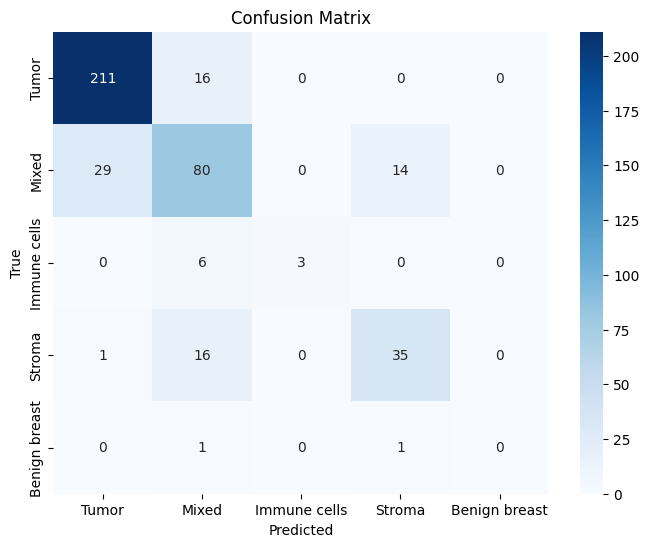

In [56]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [57]:
class_report = classification_report(y_test, y_pred_classes, target_names=label_mapping.keys())
print("Classification Report:\n", class_report)

Classification Report:
                precision    recall  f1-score   support

        Tumor       0.88      0.93      0.90       227
        Mixed       0.67      0.65      0.66       123
 Immune cells       1.00      0.33      0.50         9
       Stroma       0.70      0.67      0.69        52
Benign breast       0.00      0.00      0.00         2

     accuracy                           0.80       413
    macro avg       0.65      0.52      0.55       413
 weighted avg       0.79      0.80      0.79       413



/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f